<a href="https://colab.research.google.com/github/Meitnerium-109/citation_network_analysis/blob/main/Task_2_Community_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# For Louvain
!pip install python-louvain
import community as communityL

'''!wget "https://snap.stanford.edu/data/cit-HepPh.txt.gz"
!gunzip cit-HepPh.txt.gz
!wget "https://snap.stanford.edu/data/cit-HepPh-dates.txt.gz"
!gunzip cit-HepPh-dates.txt.gz'''

# Load edges
edge_file = 'cit-HepPh.txt'
dates_file = 'cit-HepPh-dates.txt'
citations = pd.read_csv(edge_file, sep='\t', comment='#', names=['source','target'])
dates = pd.read_csv(dates_file, sep='\t', names=['node','date'], comment='#')
dates['date'] = pd.to_datetime(dates['date'], format='%Y-%m-%d', errors='coerce')

G = nx.from_pandas_edgelist(citations, 'source','target', create_using=nx.DiGraph())
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Graph has 34546 nodes and 421578 edges.


Static community detection:
I will demonstrate two methods on the graph at a chosen snapshot (time T).
T = 2000, i.e, I will use the subgraph of papers published on or before 2000.

(Note: According to the exploratory data analysis hypotheses 2000 represents the culmination of different subfields research into a consolidated field of interconnected study.)

 Subset Graph at Time T=2000:

In [11]:

T = 2000
valid_nodes = []
for idx, row in dates.dropna().iterrows():
    if row['date'].year <= T:
        valid_nodes.append(row['node'])

G_t = G.subgraph(valid_nodes).copy()
print(f"Snapshot at {T}: {G_t.number_of_nodes()} nodes, {G_t.number_of_edges()} edges")

undirected_t = G_t.to_undirected()

Snapshot at 2000: 25893 nodes, 265032 edges


Label Propagation method.

In [31]:

lp_comms = nx.algorithms.community.label_propagation_communities(undirected_t)
lp_comms_list = list(lp_comms)
print(f"Label Propagation found {len(lp_comms_list)} communities.")

# Quick size check
lp_sizes = [len(c) for c in lp_comms_list]


Label Propagation found 796 communities.


Plotting sizes of these communities:

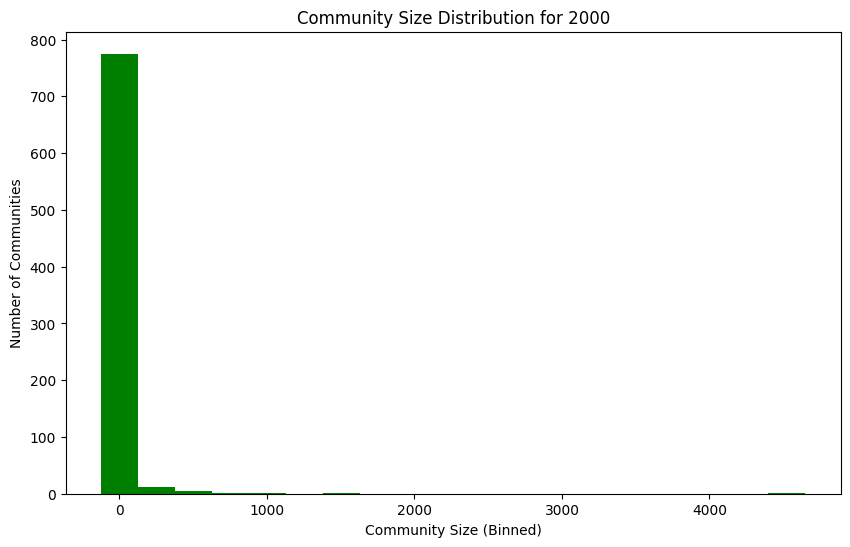

In [33]:
bins = np.linspace(0, max(lp_sizes), 20)  # Create 20 bins for community sizes
hist, bin_edges = np.histogram(lp_sizes, bins=bins)

plt.figure(figsize=(10, 6))
plt.bar(bin_edges[:-1], hist, width=bin_edges[1] - bin_edges[0], color='green')
plt.xlabel("Community Size")
plt.ylabel("Number of Communities")
plt.title(f"Community Size Distribution for {T}")
plt.show()

Most communities are relatively small, between the size of 0 to 2000. However there is a tiny sliver of size >4000. The first chunk could represent the emerging new fields that were predicted to occur in 2000, and the second chunk represents the consolidated network of all previous work before the trajectory shift.
Since this method works on neighbours, this hypothesis makes sense.

Static community detection: Louvain method:
The louvain method uses modularity as a measure to optimize formation of communities. Modularity compares the actual density of edges within communities to what would be expected if the edges were randomly distributed. Higher modularity values indicate a better-defined community structure. First, it optimizes locally: seeing if modularity improves if nodes are moved to a neighbourhing community. Then once no more optimizations can be made, all nodes in a community are aggregated into a node, and a coarser graph is obtained on which the process repeats.

In [34]:
partition = communityL.community_louvain.best_partition(undirected_t)
# partition is a dict: node -> community_id
num_louvain_comms = len(set(partition.values()))
print(f"Louvain found {num_louvain_comms} communities.")

Louvain found 217 communities.


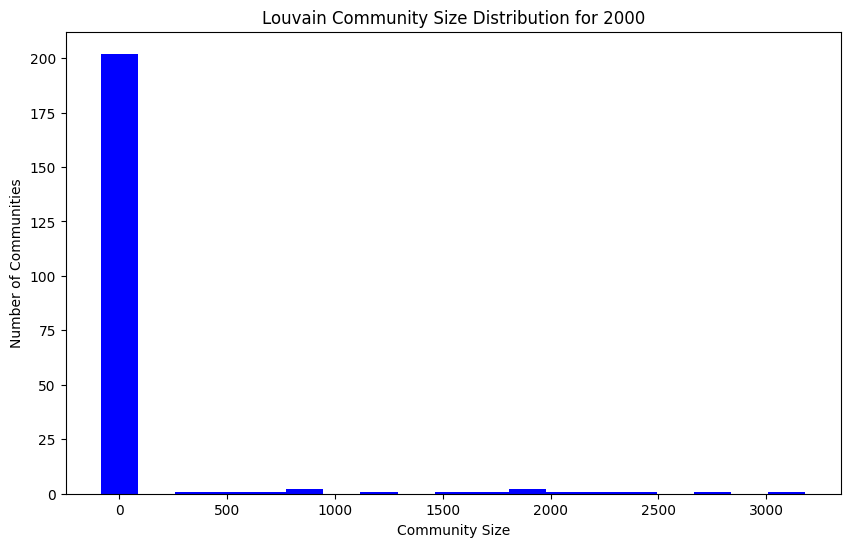

In [36]:
community_sizes = {}
for node, comm_id in partition.items():
    if comm_id not in community_sizes:
        community_sizes[comm_id] = 0
    community_sizes[comm_id] += 1
sizes = list(community_sizes.values())
bins = np.linspace(0, max(sizes), 20)
hist, bin_edges = np.histogram(sizes, bins=bins)
plt.figure(figsize=(10, 6))
plt.bar(bin_edges[:-1], hist, width=bin_edges[1] - bin_edges[0], color='blue')  # Using blue for Louvain
plt.xlabel("Community Size")
plt.ylabel("Number of Communities")
plt.title(f"Louvain Community Size Distribution for {T}")
plt.show()

This is more distributed than the LP plot, however it still reflects the overall structure of communities in the year 2000: one massive chunk representing previous consolidated study, and smaller, isolated pieces of newly emerging fields and areas. Since Louvain method optimizes modularity, overall it returns a lesser number of communities however each community with more density.

Temporal community detection: Using Louvain method.

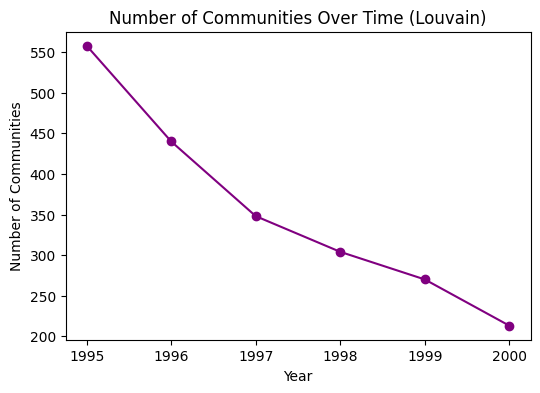

In [27]:

years = range(1995, 2001)
temporal_community_sizes = []

dates_map = dict(zip(dates['node'], dates['date']))

for y in years:
    sub_nodes = [n for n in G.nodes()
                 if n in dates_map and dates_map[n].year <= y]
    G_slice = G.subgraph(sub_nodes).to_undirected()
    partition = communityL.community_louvain.best_partition(G_slice)
    num_comms = len(set(partition.values()))
    temporal_community_sizes.append((y,num_comms))

# Plot
x_vals = [t[0] for t in temporal_community_sizes]
y_vals = [t[1] for t in temporal_community_sizes]

plt.figure(figsize=(6,4))
plt.plot(x_vals, y_vals, marker='o', color='purple')
plt.title("Number of Communities Over Time (Louvain)")
plt.xlabel("Year")
plt.ylabel("Number of Communities")
plt.show()

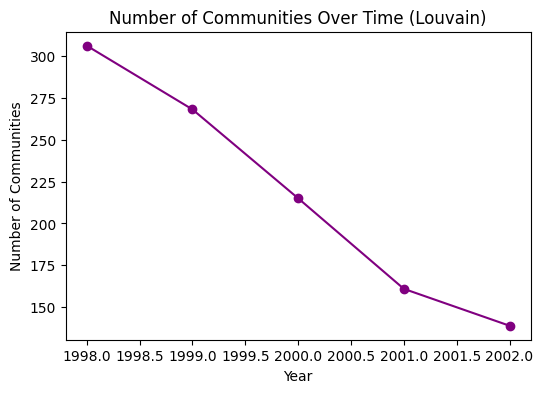

In [37]:

years = range(1998, 2003)
temporal_community_sizes = []

dates_map = dict(zip(dates['node'], dates['date']))

for y in years:
    sub_nodes = [n for n in G.nodes()
                 if n in dates_map and dates_map[n].year <= y]
    G_slice = G.subgraph(sub_nodes).to_undirected()
    partition = communityL.community_louvain.best_partition(G_slice)
    num_comms = len(set(partition.values()))
    temporal_community_sizes.append((y,num_comms))

# Plot
x_vals = [t[0] for t in temporal_community_sizes]
y_vals = [t[1] for t in temporal_community_sizes]

plt.figure(figsize=(6,4))
plt.plot(x_vals, y_vals, marker='o', color='purple')
plt.title("Number of Communities Over Time (Louvain)")
plt.xlabel("Year")
plt.ylabel("Number of Communities")
plt.show()